In [1]:
import os
from os import path
import shutil
import time
import copy
import numpy as np
import pandas as pd

#Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Data Loading and Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.makedirs("dataset/")

##### Unzip

In [6]:
!unzip /content/drive/MyDrive/Learn_Pytorch/workshop/NUMTA.zip -d /content/dataset/NUMTA

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/NUMTA/training-e/e11778.png  
  inflating: /content/dataset/NUMTA/training-e/e11779.png  
  inflating: /content/dataset/NUMTA/training-e/e11780.png  
  inflating: /content/dataset/NUMTA/training-e/e11781.png  
  inflating: /content/dataset/NUMTA/training-e/e11782.png  
  inflating: /content/dataset/NUMTA/training-e/e11783.png  
  inflating: /content/dataset/NUMTA/training-e/e11784.png  
  inflating: /content/dataset/NUMTA/training-e/e11785.png  
  inflating: /content/dataset/NUMTA/training-e/e11786.png  
  inflating: /content/dataset/NUMTA/training-e/e11787.png  
  inflating: /content/dataset/NUMTA/training-e/e11788.png  
  inflating: /content/dataset/NUMTA/training-e/e11789.png  
  inflating: /content/dataset/NUMTA/training-e/e11790.png  
  inflating: /content/dataset/NUMTA/training-e/e11791.png  
  inflating: /content/dataset/NUMTA/training-e/e11792.png  
  inflating: /content/dataset/NUMTA/training-e/e1

In [8]:
# Hyperparameters
# shopne pawa value
batch_size = 256
num_iters = 3200
input_shape = 28*28 # num_features = 784
output_shape = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
PATH = 'dataset/NUMTA/'
TRAIN_PATH = 'dataset/NUMTA/training-a/'
TEST_PATH = 'dataset/NUMTA/testing-all-corrected/testing-a/'
os.listdir(PATH)

['testing-b',
 'training-b',
 'testing-d',
 'training-b.csv',
 'training-c',
 'training-e',
 'testing-auga',
 'testing-c',
 'training-d.csv',
 'testing-a',
 'training-c.csv',
 'training-d',
 'training-a',
 'testing-augc',
 'training-e.csv',
 'training-a.csv',
 'testing-all-corrected',
 'testing-f',
 'testing-e']

In [10]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L') # 'L' mode image means it is a single channel image
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [11]:
df = pd.read_csv(PATH + "training-a.csv")[['filename', 'digit']]
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [12]:
mean = [0.5,]
std = [0.5, ]

transform = test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [13]:
dataset = Dataset(df, TRAIN_PATH, transform)

In [14]:
len(dataset)

19702

## Data Splitting

Training Set, Validation Set, Testing Set

In [15]:
# split data 20% for validation
val_size = 0.2

# obtain training indices that will be used for validation
dataset_size = len(dataset)

# mix data
# indices of all data
indices = list(range(dataset_size))

# random the index
np.random.shuffle(indices)

split = int(np.floor(val_size * dataset_size))

# divied into two part
train_idx, val_idx = indices[split:], indices[:split]

In [16]:
# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

print("Train Samples: ",len(train_idx))
print("Validation Samples: ",len(val_idx))

Train Samples:  15762
Validation Samples:  3940


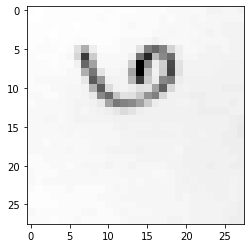

In [17]:
show_img = dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [18]:
dataset[1][1] #label

3